# Bank churn analysis and prediction

Importing the necessary libraries

In [1]:
# Libraries for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Diferent preprocessors and matrices from sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-03-18 13:06:29.962333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 13:06:29.962547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 13:06:30.170742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Importing the datasets

In [2]:
# This is the orginal bank churn data
original_churn_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv',
                                 index_col='RowNumber')

# This is the competition data which is synthesized form the original data
competition_churn_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv',
                         index_col='id')

# This is the test data for competition
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv',
                   index_col='id')

# This is sample submission dataset
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv',
                                index_col='id')

Welcome to Binary Classification with Bank Churn Dataset competition! Here we will predict a customer churn based on their information. The dataset contains 13 columns:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no)
- The metric we will use is Area Under the ROC Curve.

In [3]:
# Droping customer id and surname as they don't have any significance in our case
columns_to_drop = ['CustomerId','Surname']
original_churn_data.drop(columns_to_drop, axis=1, inplace=True)
competition_churn_data.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

In [4]:
# Concatination the original bank churn data and competition bank churn data
churn_data = pd.concat([original_churn_data, competition_churn_data], axis=0)

# Exploratory Data Analysis

In [5]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175036 entries, 1 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      175036 non-null  int64  
 1   Geography        175035 non-null  object 
 2   Gender           175036 non-null  object 
 3   Age              175035 non-null  float64
 4   Tenure           175036 non-null  int64  
 5   Balance          175036 non-null  float64
 6   NumOfProducts    175036 non-null  int64  
 7   HasCrCard        175035 non-null  float64
 8   IsActiveMember   175035 non-null  float64
 9   EstimatedSalary  175036 non-null  float64
 10  Exited           175036 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 16.0+ MB


We have 4 null values. Lets check the duplicates.

In [6]:
print('Duplicate entries:', churn_data.duplicated().sum())

Duplicate entries: 571


We will drop the duplicates and null values

In [7]:
churn_data.dropna(axis=0, inplace=True)
churn_data.drop_duplicates(inplace=True)

In [8]:
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,174461.000000,174461.000000,174461.000000,174461.000000,174461.000000,174461.000000,174461.000000,174461.000000,174461.000000
mean,656.121970,38.172737,5.019999,56639.158617,1.553184,0.751285,0.498570,111891.040999,0.211520
std,81.110198,8.965629,2.811113,62978.189713,0.549289,0.432269,0.499999,50792.480427,0.408387
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,73322.680000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116971.050000,0.000000
75%,710.000000,42.000000,7.000000,120723.170000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


<Axes: >

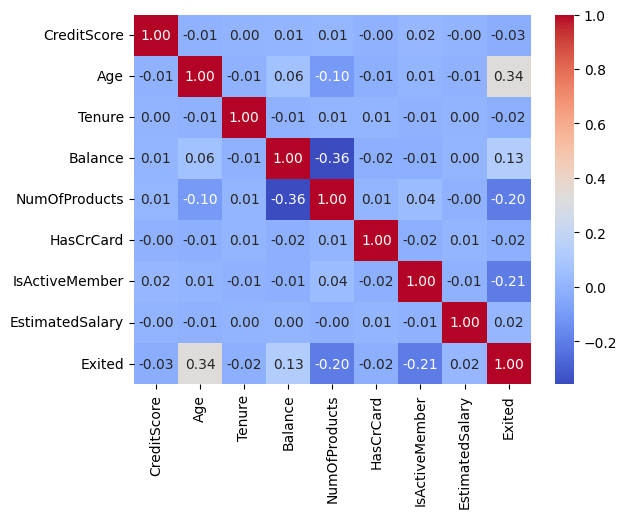

In [9]:
# Creating a heatmap of correlation of numerical variables
sns.heatmap(churn_data.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")

We observe that is is a low correlation for my variables with exited. We will test out model with and without the low correlated variables later on. berfore that we will do some more test to check the relation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


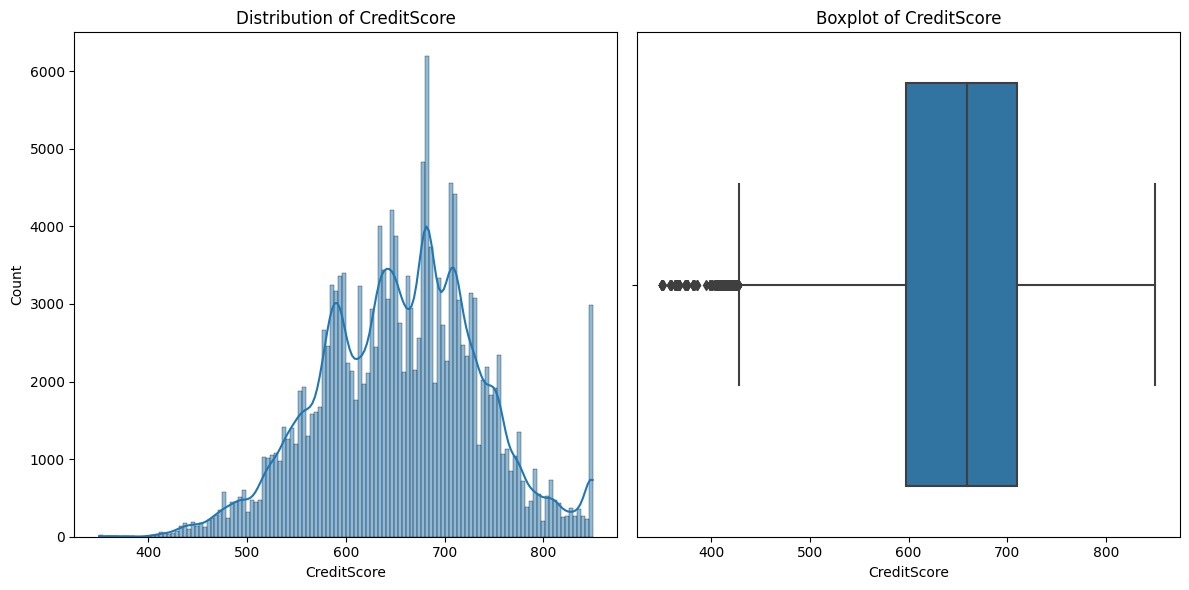

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


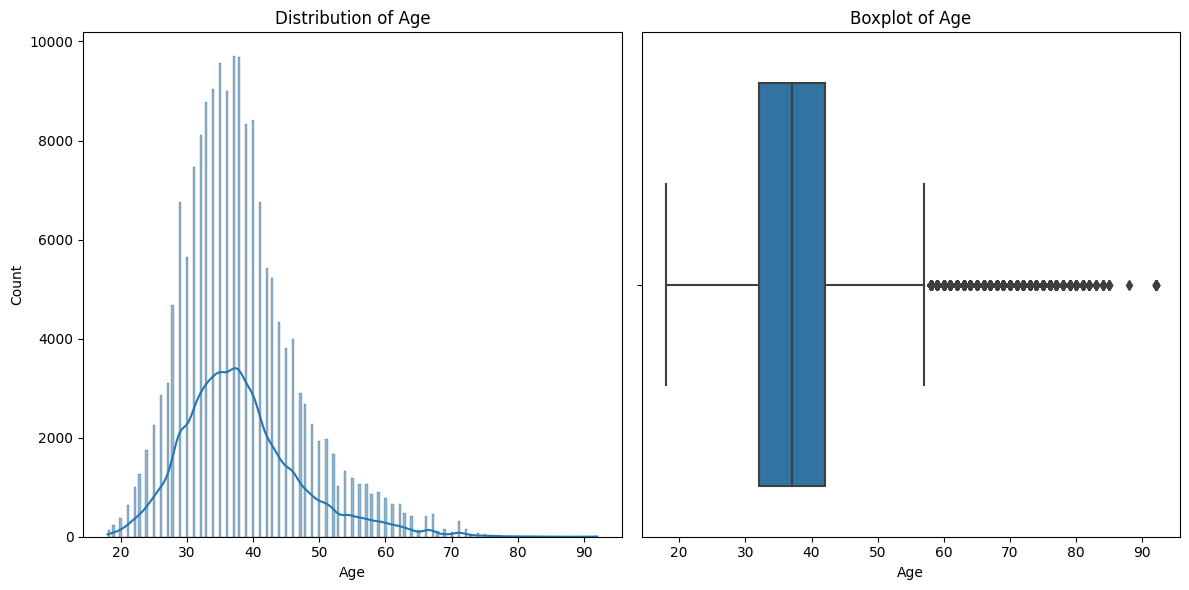

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


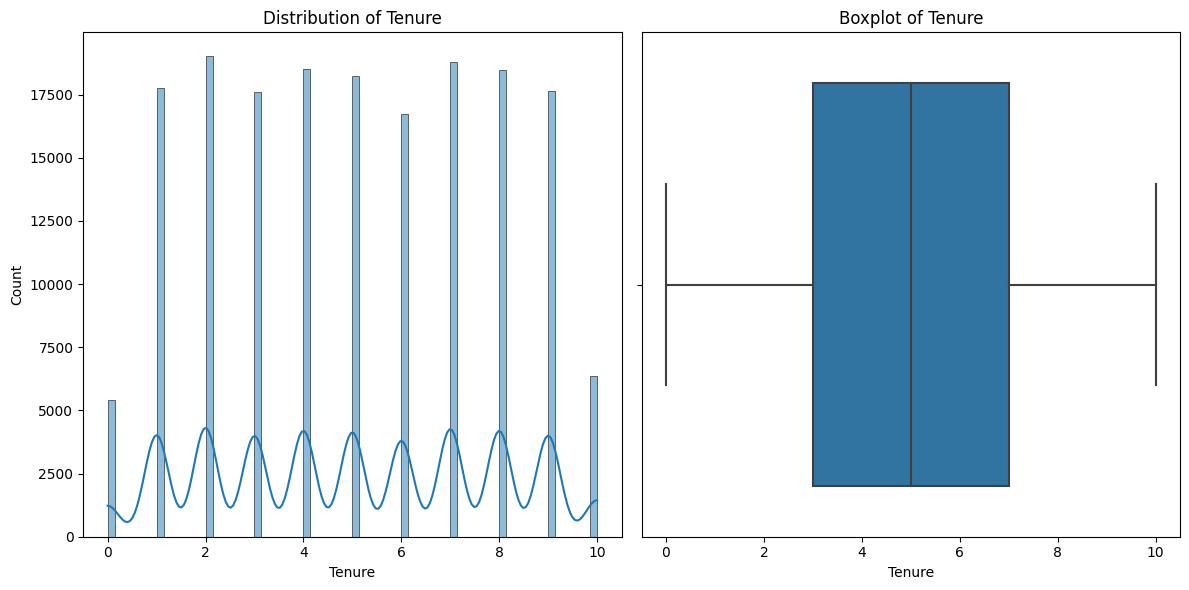

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


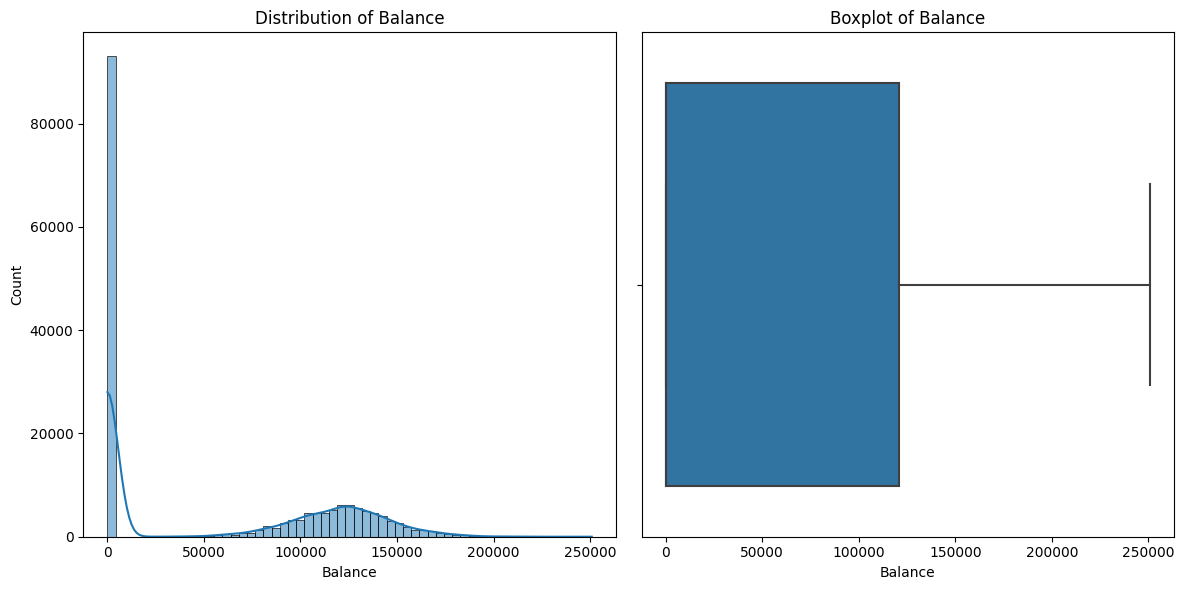

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


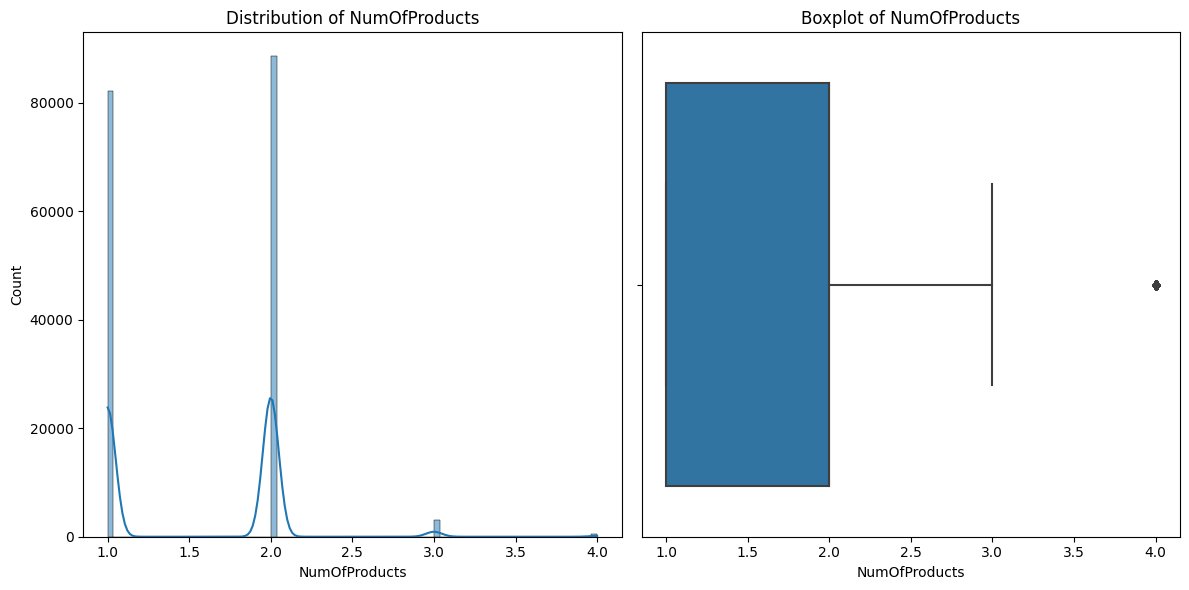

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


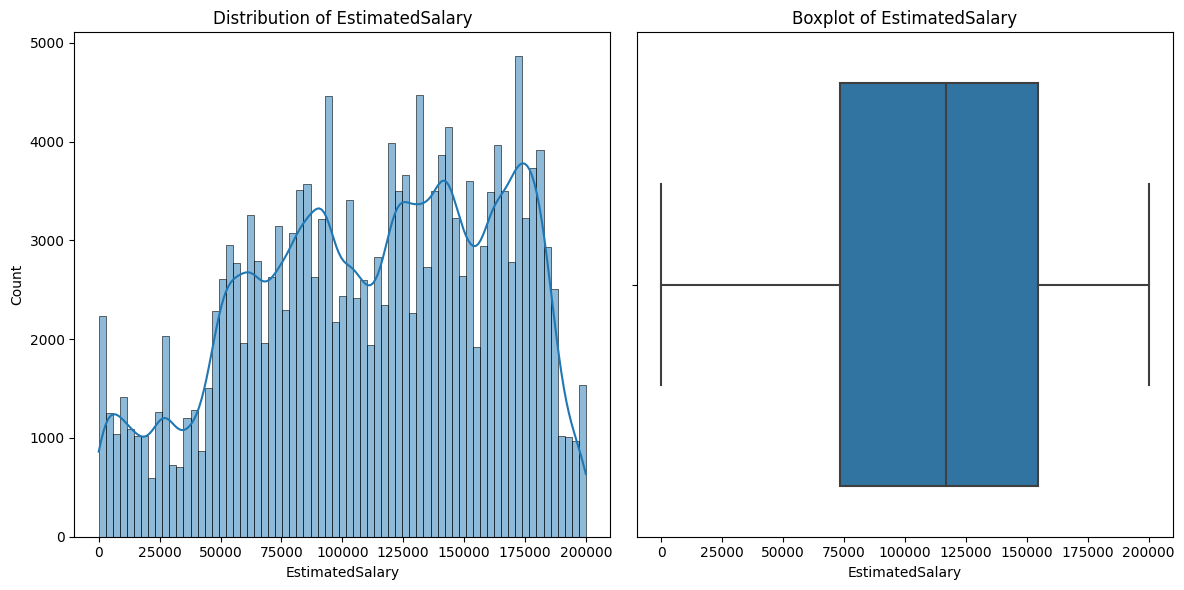

In [10]:
# Getting numerical columns
columns_to_plot = churn_data[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']].columns

# Iterate over numerical columns
for i, column in enumerate(columns_to_plot):
    # Creating figure and subplots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    # Ploting histogram
    sns.histplot(x=column, data=churn_data, kde=True)
    plt.title(f'Distribution of {column}')

    plt.subplot(1, 2, 2)
    
    # Ploting boxplot
    sns.boxplot(x=column, data=churn_data)
    plt.title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()


**From the above plot we observe that:**
- There is many people having credit score 85 which is not an outlier as it is possible to have max credit score.
- In age there are outliers but it a also possible to have age greater than 90 and they are not abnormal.
- A lot of people have 0 balance which is also ok.
- some people have 4 products which is also ok.

Now lets observe the categorical variables and their effect on the target variable.

I will use chi-square test for that;The chi-square test is a statistical tool used to check if two categorical variables are related or independent.

Column: HasCrCard
Chi-square value: 78.5336569695977
p-value: 7.8646800771188335e-19


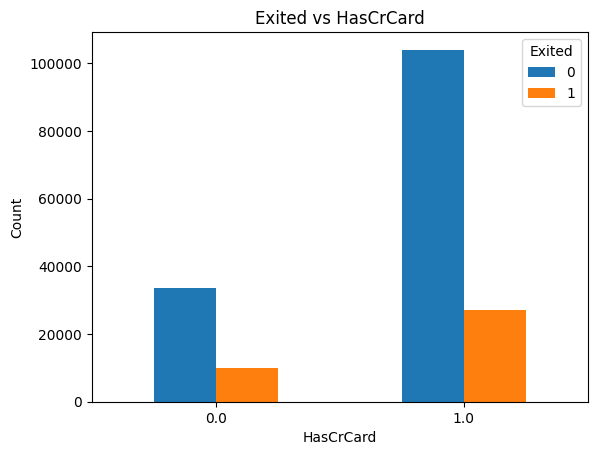

Column: IsActiveMember
Chi-square value: 7497.072826076961
p-value: 0.0


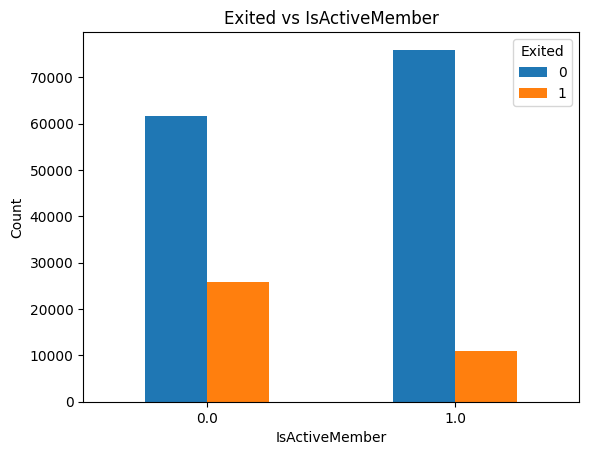

Column: Gender
Chi-square value: 3630.6132491354992
p-value: 0.0


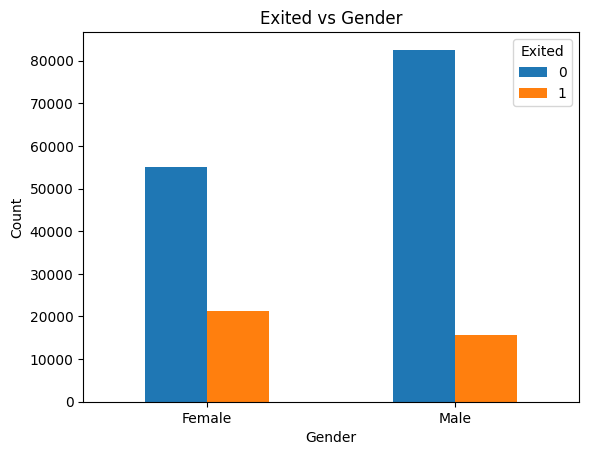

Column: Geography
Chi-square value: 7593.142048031765
p-value: 0.0


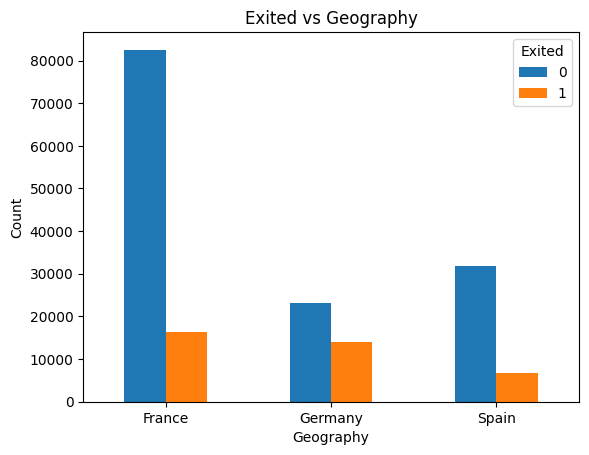

In [11]:
# Column to analyze
columns_to_analyze = ['HasCrCard', 'IsActiveMember', 'Gender', 'Geography']

# Looping over the columns
for column in columns_to_analyze:
    # Creating a contingency table
    contingency_table = pd.crosstab(churn_data[column], churn_data['Exited'])
    
    # Performing chi-square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Column: {column}")
    print("Chi-square value:", chi2)
    print("p-value:", p)
    
    # Plotting a grouped bar plot
    contingency_table.plot(kind='bar')
    plt.title(f'Exited vs {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Rotate x-axis labels if needed
    plt.legend(title='Exited')
    plt.show()

From the result of the chi-square test we conclude that the null hypothesis is incorrect(there is no relation between these categorical variables and target variable). There is a relation between them(Alternative hypothesis).

Also we can see that customer retention in France is very good as compared to Germany and Spain

# Data Preprocessing

In [12]:
# Defining the target variable and making features and target dataset
target_variable = 'Exited'
x = churn_data.drop(target_variable, axis=1)
y = churn_data[target_variable]

In [13]:
# Getting the numerical and categorical columns from the features for preprocessing
numerical_columns = x.select_dtypes(include=['number']).columns.tolist()
categorical_columns = x.select_dtypes(include=['object', 'category']).columns.tolist()

# Defining the preprocessor for our data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # No transformation for numerical columns
        ('cat', OneHotEncoder(), categorical_columns)
    ])

In [14]:
# Defining function to apply the preprocessing and train the the respective model using cross-validation
def evaluate_model(classifier, x, y, preprocessor=None, n_splits=5):
    # Create the pipeline
    if preprocessor is None:
        pipeline = Pipeline([
            ('classifier', classifier)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(pipeline, x, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    # Print the results
    for metric in cv_results.keys():
        print(f"{metric.capitalize()}: {np.mean(cv_results[metric])}")


# Modeling

I will try different model and use only one for submission. Here are the result for all models i tried:

**Logistic Regression:**  
Accuracy: 0.8322261363845401  
Precision: 0.6929303487466798  
Recall: 0.3720122088905485  
F1-score: 0.4840023824527431   
ROC AUC: 0.8140509699702809  

**Decision Tree:**  
Accuracy: 0.7951978778154164  
Precision: 0.5160161396976255  
Recall: 0.5278307923846072  
F1-score: 0.5217697455640233  
ROC AUC: 0.6991617799668366  

**Random Forest:**  
Accuracy: 0.8548615988167019  
Precision: 0.709595299159175  
Recall: 0.5315705673653404  
F1-score: 0.607785987164061  
ROC AUC: 0.8673630736325121  

**Gradient boosting:**  
Accuracy: 0.8637231332187293  
Precision: 0.7511535059529748  
Recall: 0.5321120036833751  
F1-score: 0.6228977489774747  
ROC AUC: 0.8870712942554391  

**KNeighbors Classifier:**  
Accuracy: 0.846619039134589  
Precision: 0.673407056323988  
Recall: 0.5337381631369491  
F1-score: 0.595489838274743  
ROC AUC: 0.8247350317282821  

**MLP Classifier:**  
Accuracy: 0.8639868079167521  
Precision: 0.7392092708418208  
Recall: 0.5533564829348333  
F1-score: 0.6322607255628455  
ROC AUC: 0.8858596957028215

**XGBoost:**  
Accuracy: 0.8649618987148578  
Precision: 0.7446638003439424  
Recall: 0.5545209032005204  
F1-score: 0.6356477283787048  
ROC AUC: 0.8877560566633701  

**LightGBM:**  
Accuracy: 0.8651733143244662  
Precision: 0.7429039703279482  
Recall: 0.5545229952096296  
F1-score: 0.6350197149287281  
ROC AUC: 0.8882216797744897  

**Cat Boost:**  
Accuracy: 0.8638943186508323  
Precision: 0.7450587551029202  
Recall: 0.5462238512675428  
F1-score: 0.6303137267204082  
ROC AUC: 0.8866893460543347  


In [15]:
# Using XGBoost Classifier
params = {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8}
xgb = XGBClassifier(**params)
evaluate_model(xgb, x, y, preprocessor=preprocessor)

Fit_time: 1.3945947170257569
Score_time: 0.21489691734313965
Test_accuracy: 0.8652592850479082
Test_precision: 0.7434393499935716
Test_recall: 0.5542790450394681
Test_f1: 0.635066756885162
Test_roc_auc: 0.8884761905195783


Best Parameters using GridSearchCV: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8}  

In [16]:
# Using LightGBM Classifier
lgbm = LGBMClassifier(verbose=0)
evaluate_model(lgbm, x, y, preprocessor=preprocessor)

Fit_time: 3.0938061237335206
Score_time: 0.5965778827667236
Test_accuracy: 0.8650013503722007
Test_precision: 0.7416949692595949
Test_recall: 0.5550920678560531
Test_f1: 0.6349618416230348
Test_roc_auc: 0.8883059222384734


Best Parameters using GridSearchCV : {'border_count': 64, 'colsample_bylevel': 0.95, 'depth': 7, 'iterations': 250, 'leaf_estimation_iterations': 3, 'scale_pos_weight': 2, 'subsample': 0.85}

In [17]:
# Using Catboost Classifier
params = {'border_count': 64, 'colsample_bylevel': 0.95, 'depth': 7, 'iterations': 250, 'leaf_estimation_iterations': 3, 'scale_pos_weight': 2, 'subsample': 0.85}
cb = CatBoostClassifier(**params, verbose=0)
evaluate_model(cb, x, y, preprocessor=preprocessor)

Fit_time: 6.544446706771851
Score_time: 0.6836033344268799
Test_accuracy: 0.8531476920883552
Test_precision: 0.6447768233721718
Test_recall: 0.6808574164457266
Test_f1: 0.6623210105989268
Test_roc_auc: 0.8880092963526142


#  Neural Network

In [18]:
# Applying the preprocessing on the training and testing data
x_preprocessed = preprocessor.fit_transform(x)
test_preprocessed = preprocessor.transform(test)

# Defining early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Defining the model(after some iteration these hyperparameters worked best)
model = Sequential([
    Dense(32, activation=LeakyReLU(alpha=0.1), input_shape=[x_preprocessed.shape[1]]),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.4),  # Add Dropout layer with dropout rate of 0.2
    Dense(64, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(16, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(8, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation results of nueral network:  
Accuracy: 0.8669524944974322  
Precision: 0.761889356195406  
Recall: 0.5209600707886296   
F1-score: 0.6188004992445642  
ROC AUC: 0.8862380816306976  

In [19]:
history = model.fit(x_preprocessed, y, epochs=1000, batch_size=256, validation_data=(x_preprocessed, y), callbacks=[early_stopping])

Epoch 1/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7364 - loss: 0.5995 - val_accuracy: 0.8476 - val_loss: 0.3515
Epoch 2/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8317 - loss: 0.3972 - val_accuracy: 0.8582 - val_loss: 0.3386
Epoch 3/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8375 - loss: 0.3802 - val_accuracy: 0.8604 - val_loss: 0.3354
Epoch 4/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8438 - loss: 0.3717 - val_accuracy: 0.8626 - val_loss: 0.3318
Epoch 5/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8440 - loss: 0.3680 - val_accuracy: 0.8630 - val_loss: 0.3298
Epoch 6/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8450 - loss: 0.3655 - val_accuracy: 0.8636 - val_loss: 0.3291
Epoch 7/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8489 - loss: 0.3581 - val_accuracy: 0.8635 - val_loss: 0.3287
Epoch 8/1000
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8510 - loss: 0.3578 - 

In [20]:
pred = model.predict(test_preprocessed)

3439/3439 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


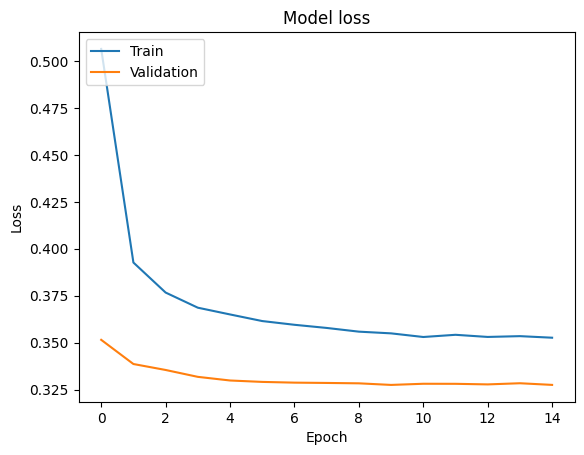

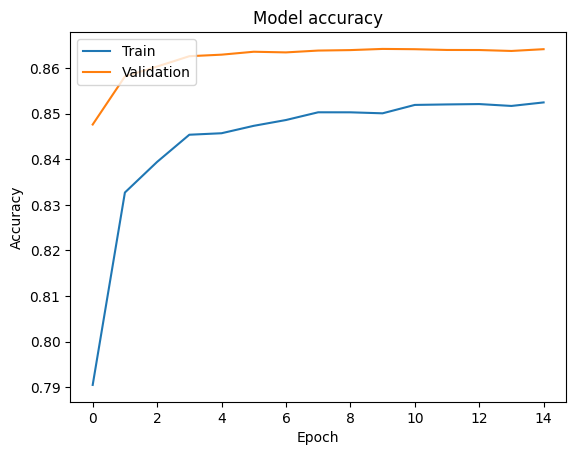

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
submission = pd.DataFrame(pred, index=sample_submission.index, columns=sample_submission.columns)
submission.to_csv('Bank_churn_predictions')

Thanks for sticking for this long.  
If you liked the notebool then give it a thumbs up👍

Unitil next time! 

Allah Hafiz